In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import json
import os
from scipy import stats
import pandas as pd
import datetime
from probssm.ivp import sir_rhs

In [113]:
dir_list = [el for el in os.listdir() if el.startswith("run_can")]
dir_list.sort(key=lambda x: os.path.getmtime(x))
run = dir_list[-1]
print(dir_list)
print("plotting run : {}".format(run))

['run_can_2023-03-05_16-32-32', 'run_can_2023-03-06_12-17-42', 'run_can_2023-03-06_12-18-38', 'run_can_2023-03-06_12-19-22', 'run_can_2023-03-06_12-20-13', 'run_can_2023-03-06_12-21-32', 'run_can_2023-03-06_12-22-37', 'run_can_2023-03-06_12-23-52', 'run_can_2023-03-06_12-24-47', 'run_can_2023-03-06_12-25-26', 'run_can_2023-03-06_12-26-05', 'run_can_2023-03-06_12-26-57', 'run_can_2023-03-06_12-29-29', 'run_can_2023-03-06_12-30-09']
plotting run : run_can_2023-03-06_12-30-09


In [114]:
arr = np.load(run + "/posterior_first.npz")
data = np.load(run + "/data_info.npz")
projections = np.load(run + "/projections.npz")
filter_info = np.load(run + "/filtering_info.npz", allow_pickle=True)["arr_0"]
R_dir = "../r_env/"
epiestim = pd.read_csv(R_dir + "result_R.csv")
with open(run + "/info.json") as f:
    info = json.load(f)

In [115]:
def beta_link_fn(x, info, data, y_offset=0.0, exp=True):
    slope = info["sigmoid_slope"]
    x_offset = -scipy.special.logit(data["beta_prior_mean"])
    if exp:
        return np.exp(x)
    else:
        return scipy.special.expit(slope * (x - x_offset)) + y_offset
    
def prop_std(state_idx, step):
    return np.exp(arr["means"][::step, state_idx]) * np.sqrt(arr["covs"][::step, state_idx, state_idx])

## Sanity Checks

In [116]:
logS = arr["means"][:, 0]
S = np.exp(logS)
logSp = arr["means"][:, 1]
Sp = S * logSp
logI = arr["means"][:, 3]
I = np.exp(logI)
logIp = arr["means"][:, 4]
Ip = I * logIp
logR = arr["means"][:, 6]
R = np.exp(logR)
logRp = arr["means"][:, 7]
Rp = R * logRp
beta = arr["means"][:, 9]
beta_link = beta_link_fn(beta, info, data, exp=True)

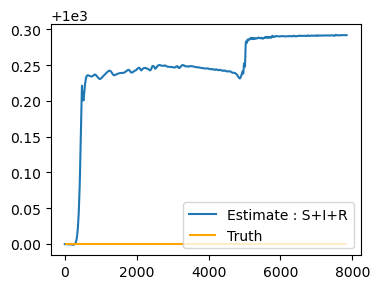

In [117]:
#Check that S + I + R = 1000 with small error (1e-2) due to diffusion noise
plt.figure(figsize=(4,3))
plt.plot(S + I + R, label="Estimate : S+I+R")
plt.hlines(data["population"], 0, len(S), color="orange", label="Truth")
plt.legend()

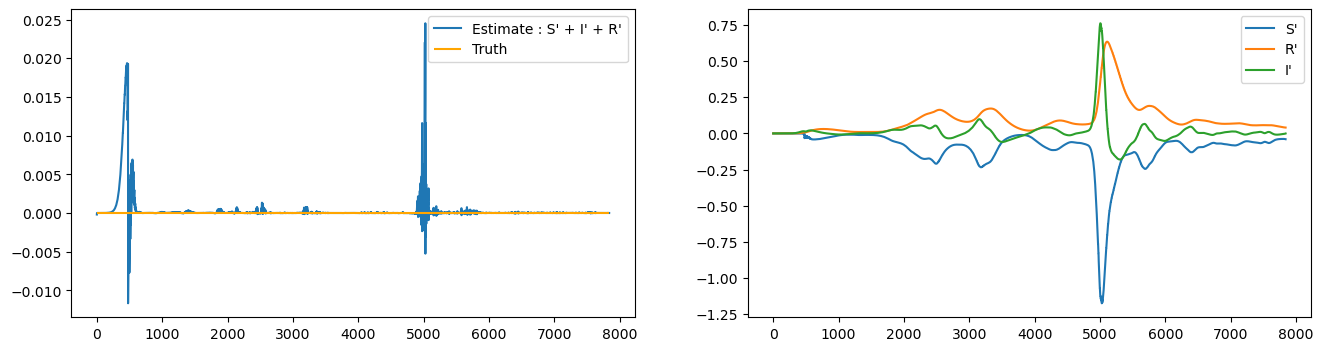

In [118]:
#Check that S' + I' + R' = 0
fig, axs = plt.subplots(1,2, figsize=(16,4))
axs[0].plot(Sp + Ip + Rp, label="Estimate : S' + I' + R'")
axs[0].hlines(0, 0, len(S), color="orange", label="Truth")
axs[0].legend()
axs[1].plot(Sp, label="S'")
axs[1].plot(Rp, label="R'")
axs[1].plot(Ip, label="I'")
axs[1].legend()

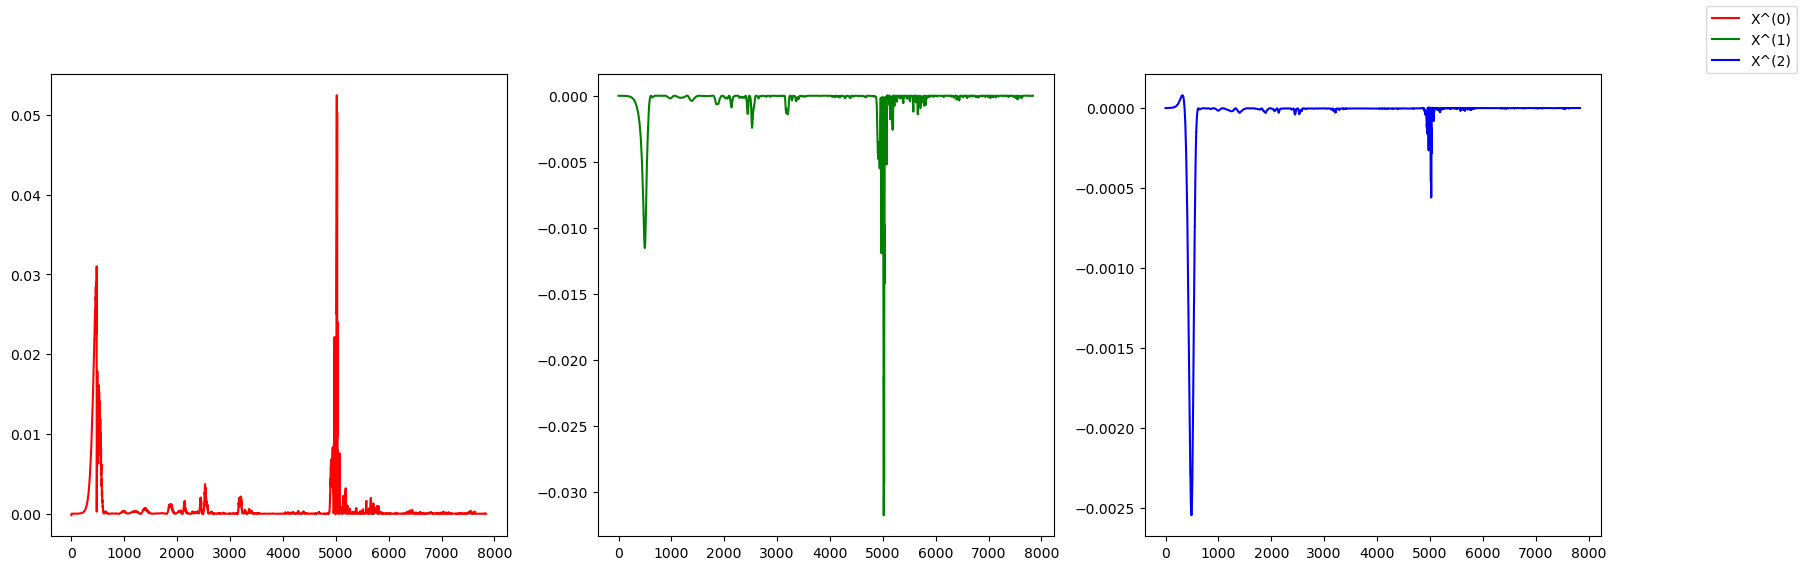

In [119]:
#Check that x'(t) = f(x(t)) for SIRS model.

fig, axs = plt.subplots(1,3, figsize=(20,6))
axs[0].plot(Sp + S * I * beta_link/ data["population"] - data["eta"] * R, 'r', label="X^(0)")
axs[1].plot(Ip - S * I *beta_link /data["population"] + data["gamma"] * I, 'g', label="X^(1)")
axs[2].plot(Rp - data["gamma"] * I + data["eta"]*R, 'b', label = "X^(2)")
fig.legend()

In [120]:
#Check if we are extracting the right indices when plotting. 
#If its a list of float int, we good
data["dense_grid"][::1+(int(1/info["filter_step_size"]))][:10]

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

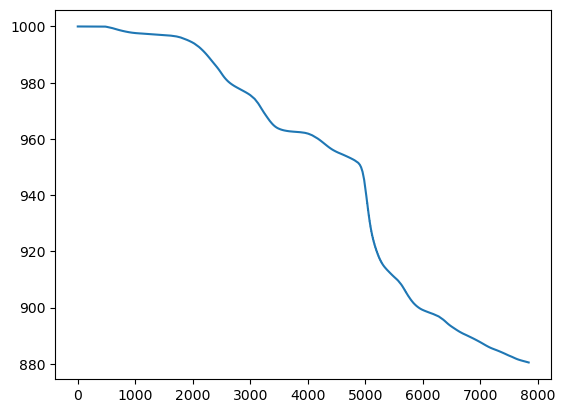

In [121]:
plt.plot(np.exp(arr["means"][:,0]))

## Plotting results

Skipping first 90 days...
Population size of 1000.0
Negligible error on case counts (<1)
Data Covariance : 5e-09
ODE Covariance : 1e-05
Diffusion intensity (beta) : 0.005
Diffusion intensity (x) : 0.005
Step Size of ODE filter : 0.16667
ODE parameters : gamma = 0.04517, eta = 0.00549


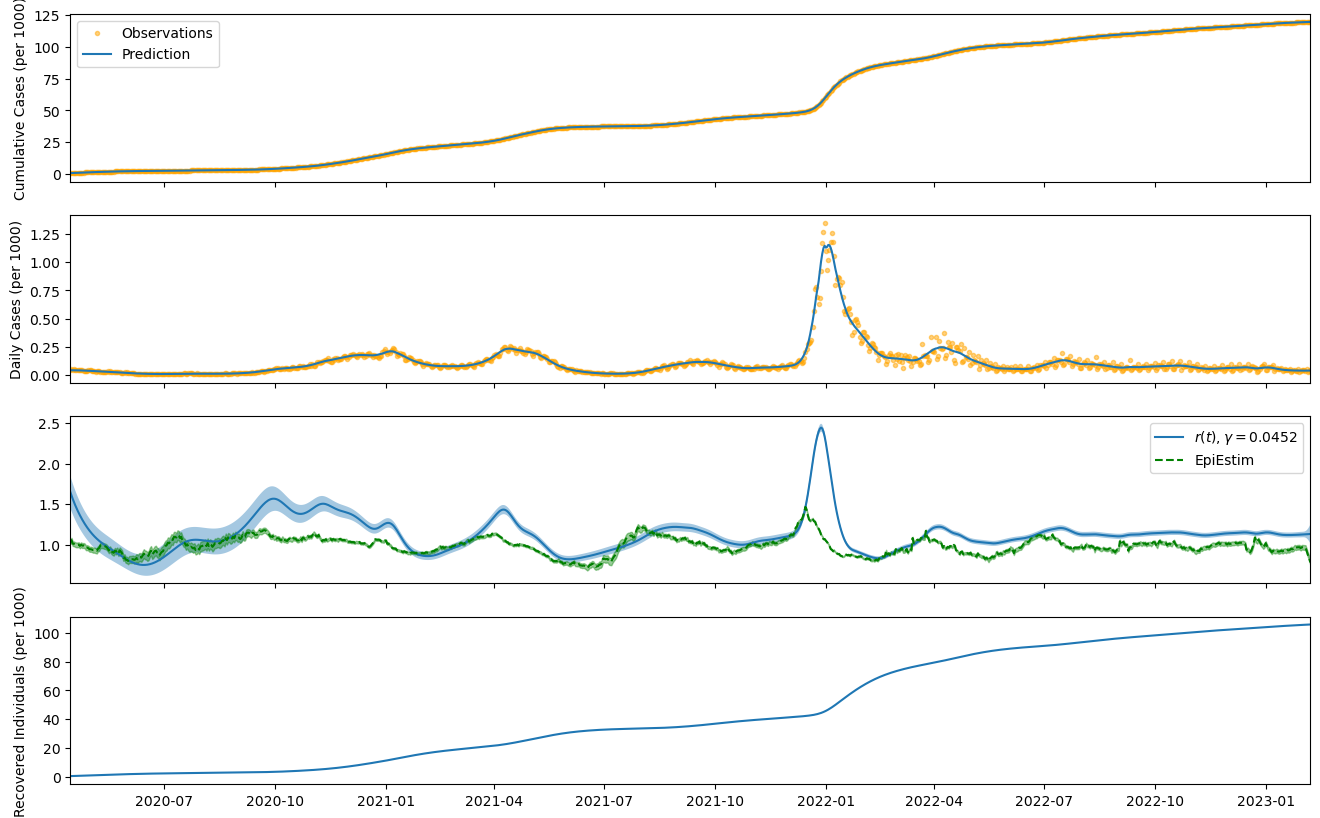

In [122]:
tmin_idx, tmax_idx = data["time_domain"].astype(int)
dates = data["date_range_x"][tmin_idx : tmax_idx]

N = 1000.0
skip_first_n_days = 90
print(f"Skipping first {skip_first_n_days} days...")
print(f"Population size of {N}")

#step is 1/filter_step_size
step = 1+int(1/info["filter_step_size"])

obs = pd.DataFrame({"daily": np.abs(np.diff(data["sir_data"][:, 0], prepend=data["sir_data"].max())),
              "cum" : N - data["sir_data"][:,0]},
              index = dates) 

#(log_S)' = (1/S) S'(t) -> S'(t) = S(t) * (log_S)'. Daily case count is -S'(t). Cum cases is N - S(t)
predicted_daily_cases = - (np.exp(arr["means"][:, 0]) * arr["means"][:,1])[::step] 
predicted_cum_cases = N - np.exp(arr["means"][:, 0])[::step]

# sigma_S = sigma_logS * d/dS (f(S)) = sigma_logS * exp(S)
pred_cum_err = 3 * (np.sqrt(arr["covs"][:, 0,0]) * np.exp(arr["means"][:, 0]))[::25]
if pred_cum_err.mean() < 1 : print("Negligible error on case counts (<1)")
    
r_t_high = (beta_link_fn(arr["means"][:,-2][::step], info, data) + 3*prop_std(-2, step))/data["gamma"]
r_t_low = (beta_link_fn(arr["means"][:,-2][::step], info, data) - 3*prop_std(-2, step))/data["gamma"]
r_t_mid = beta_link_fn(arr["means"][:,-2][::step], info, data)/data["gamma"]

fig,axs = plt.subplots(4, 1, figsize=(16,10), sharex=True)
axs[0].plot(obs.index, obs.cum, '.', color='orange', alpha=0.5, label="Observations")
axs[0].plot(obs.index, predicted_cum_cases, label="Prediction")
#axs[0].fill_between(obs.index, predicted_cum_cases - pred_cum_err, predicted_cum_cases + pred_cum_err, label="Predictions")
axs[0].set_ylabel("Cumulative Cases (per 1000)")
axs[0].legend()

axs[1].plot(obs.index, obs.daily, '.', color='orange', alpha=0.5)
axs[1].plot(obs.index, predicted_daily_cases)
axs[1].set_ylabel("Daily Cases (per 1000)")

axs[2].fill_between(obs.index[skip_first_n_days:], r_t_low[skip_first_n_days:], r_t_high[skip_first_n_days:], alpha = 0.4)
axs[2].plot(obs.index[skip_first_n_days:], r_t_mid[skip_first_n_days:], label=r"$r (t), \gamma = $" + "{:.4f}".format(data["gamma"]))
axs[2].plot(obs.index[skip_first_n_days:], epiestim["Median(R)"][skip_first_n_days+1:], '--', color="green", label="EpiEstim")
axs[2].fill_between(obs.index[skip_first_n_days:], epiestim["Median(R)"][skip_first_n_days+1:] - 3*epiestim["Std(R)"][skip_first_n_days+1:], epiestim["Median(R)"][skip_first_n_days+1:] + 3*epiestim["Std(R)"][skip_first_n_days+1:], color="green", alpha=0.4)
axs[2].legend()

axs[3].plot(obs.index, np.exp(arr["means"][::step,6]))
axs[3].set_ylabel("Recovered Individuals (per 1000)")

axs[0].set_xlim(dates[skip_first_n_days], dates[-1]);

print("Data Covariance : {}".format(data["data_measurement_cov"]))
print("ODE Covariance : {}".format(data["ode_measurement_cov"]))
print("Diffusion intensity (beta) : {}".format(data["beta_process_diffusion"]))
print("Diffusion intensity (x) : {}".format(data["x_process_diffusion"]))
print("Step Size of ODE filter : {:.5f}".format(info["filter_step_size"]))
print("ODE parameters : gamma = {:.5f}, eta = {:.5f}".format(data["gamma"], data["eta"]))

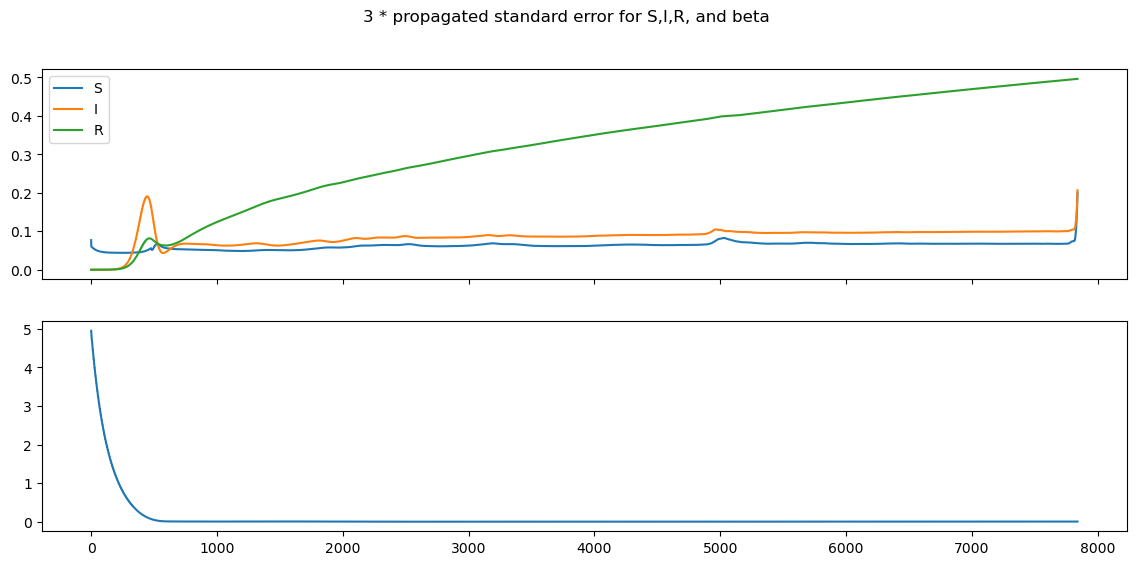

In [123]:
fig, axs = plt.subplots(2, 1, figsize=(14,6), sharex=True)
for i, state in enumerate(["S", "I", "R"]) : axs[0].plot(3 * prop_std(3*i, 1), label=state)
axs[0].legend()
axs[1].plot(3 * prop_std(-2, 1), label="beta(t)")
fig.suptitle("3 * propagated standard error for S,I,R, and beta");

In [64]:
E_x = projections["E_x"]
E0_x = projections["E0_x"]
E1_x = projections["E1_x"]
E0_beta = projections["E0_beta"]
E_beta = projections["E_beta"]
E1_beta = projections["E1_beta"]

In [65]:
state_misalignment = []
for states in arr["means"]:

    x = E_x @ states
    beta = E0_beta @ (E_beta @ states)

    state_misalignment.append((np.exp(E0_x @ x) * (E1_x @ x) - sir_rhs(0,
                                          y = np.exp(E0_x @ x),
                                          beta = beta_link_fn(beta, info, data).squeeze(),
                                          gamma = data["gamma"],
                                          population_count = data["population"])))

In [44]:
stats.multivariate_normal.logpdf(np.vstack(state_misalignment),
                  mean=np.zeros_like(state_misalignment[0]),
                  cov=np.eye(3) * data["ode_measurement_cov"]).sum()

-4.57643995213223e+32

In [144]:
np.log(data["sir_data"][:,0]).reshape(-1, 7).var(axis=1).mean()

1.4586499035694136e-07